**Install Library**

In [17]:
!pip install anytree
!pip install mycolorpy
!pip install mpl_toolkits.basemap
!pip install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement mpl_toolkits.basemap (from versions: none)
ERROR: No matching distribution found for mpl_toolkits.basemap
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Import Library**

In [18]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
from IPython.display import Image
from anytree import Node, RenderTree
from anytree.exporter import DotExporter
import graphviz
from datetime import timedelta
import math
from scipy import optimize
from scipy import stats
from mpl_toolkits.mplot3d import axes3d
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from datetime import timedelta, datetime
from mycolorpy import colorlist as mcp

%matplotlib inline

In [19]:
#from google.colab import drive
#drive.mount("/content/drive")

#jika dari dataset github
#dataset = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/USGS/eq_1970_M6.csv"
dataset = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/SCEDC/SouthCalifornia-1982-2011_Physics-of-Data.dat.txt"
data = np.genfromtxt(dataset)
df = pd.DataFrame(data, columns=['index', 'trigger', 'time', 'magnitude', 'X', 'Y', 'Z'])
df = df.sort_values(by=['time'])


In [20]:
# transformation from Cartesian to spherical coordinates
R = 6371500 # Earth's radius
df["longitude"] = np.arctan2(df["Y"],df["X"])*180/np.pi
df["latitude"] = np.arcsin(df["Z"]/np.sqrt(df["X"]**2+df["Y"]**2+df["Z"]**2))*180/np.pi
df["depth"] = np.sqrt(df["X"]**2+df["Y"]**2+df["Z"]**2) - R

# convert time from seconds to years
df['date'] = pd.to_datetime(df['time'], unit='s', origin='01/01/1982')

df.head(10)

,index,trigger,time,magnitude,X,Y,Z,longitude,latitude,depth,date
0,0.0,-1.0,0.00000,2.71,-2571956.0,-4627162.0,3520602.0,-119.067002,33.624997,-13809.831190,1982-01-01 00:00:00.000000
1,1.0,0.0,36501.39072,2.12,-2363740.0,-4787011.0,3461373.0,-116.279332,32.957092,-8808.419635,1982-01-01 10:08:21.390720
2,2.0,0.0,37488.27744,2.33,-2363746.0,-4786942.0,3461232.0,-116.279718,32.956316,-8934.808059,1982-01-01 10:24:48.277440
3,3.0,0.0,47982.51648,2.57,-2475085.0,-4664024.0,3548479.0,-117.953814,33.903121,-9828.140870,1982-01-01 13:19:42.516480
4,4.0,0.0,60268.57056,2.98,-2238642.0,-4839098.0,3469546.0,-114.825995,33.053002,-10200.061789,1982-01-01 16:44:28.570560
5,5.0,0.0,100612.80864,2.04,-2545592.0,-4588519.0,3597315.0,-119.020383,34.432610,-9486.132281,1982-01-02 03:56:52.808640
6,6.0,0.0,106358.95296,2.27,-2361034.0,-4748837.0,3502194.0,-116.435716,33.439538,-16085.205090,1982-01-02 05:32:38.952960
7,7.0,0.0,127529.37216,2.64,-2484433.0,-4558759.0,3679010.0,-118.589506,35.322173,-8339.972807,1982-01-02 11:25:29.372160
8,8.0,0.0,130364.57088,2.62,-2429713.0,-4582352.0,3681247.0,-117.933999,35.365332,-11229.990851,1982-01-02 12:12:44.570880
9,9.0,0.0,134132.56128,2.48,-2526232.0,-4571575.0,3618942.0,-118.924844,34.716838,-17140.292066,1982-01-02 13:15:32.561280


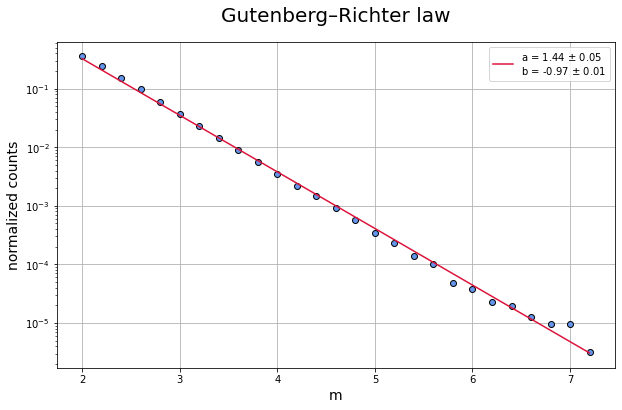

In [23]:
magnitudes = np.arange(2,8,0.2)
counts = np.zeros(magnitudes.shape[0])

# compute the number of events with magnitude M >= m
i = 0
for m in magnitudes:
    counts[i] = df[df['magnitude'] >= m]['magnitude'].count()
    i += 1

# normalize counts
norm = np.sum(counts)   
counts_n = counts/norm

# filter by removing empty bins for the log plot
counts_n_f = counts_n[counts_n!=0]
magnitudes_f = magnitudes[counts_n!=0]

# compute linear regression
reg = stats.linregress(magnitudes_f, np.log10(counts_n_f))

fig, ax = plt.subplots(figsize=(10,6))

# plot histogram
ax.plot(magnitudes_f, counts_n_f, 'o', mfc='cornflowerblue', mec='black')
# plot linear regression
label = r'a = {:.2f} $\pm$ {:.2f}'.format(reg.intercept, reg.intercept_stderr) + '\n' + r'b = {:.2f} $\pm$ {:.2f}'.format(reg.slope, reg.stderr)
plt.plot(magnitudes_f, 10**(reg.intercept + reg.slope*magnitudes_f), 'crimson', label=label)
ax.set_yscale('log')
ax.set_xlabel('m', fontsize=14)
ax.set_ylabel(r'normalized counts', fontsize=14)
ax.set_title('Gutenberg–Richter law', fontsize=20, pad=20)
plt.legend()
plt.grid()
plt.show()